In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import math
from bjontegaard_metric import *

In [2]:
def bpm(t, c0, c1, c2, c3):
    return c0+c1*t-c2*np.exp(-c3*t)

In [3]:
def QP_average(camera_positions, scenes, QPs, synthesizers, numGroups, pose_traces, numFrame):
    '''
    Compare different QPs
    synthesizer = 'AdditiveSynthesizer'
    numGroup = 1
    camera positions = '6x6'
    all pose traces
    all scenes
    '''
    doplot = False
    
    df = pd.DataFrame()
    df = pd.read_csv(f'./results/all_nG1.csv')

    for scene in scenes:
        print(scene)
        df_tmp = df
        # don't discuss sphere_6x6 camera placement 
        df_tmp = df_tmp.loc[(df_tmp["camera_position"] != 'sphere_6x6')]
        # set filter
        df_tmp = df_tmp.loc[(df_tmp['synthesizer'] == 'AdditiveSynthesizer')]
        df_tmp = df_tmp.loc[(df_tmp['camera_position'] == '6x6')]
        df_tmp = df_tmp.loc[(df_tmp['scene'] == scene)]

        df_tmp['Mbitrate'] = df_tmp['bitrate'].apply(lambda x: x*(0.000001))
        # change scene name
        df_tmp['scene'] = df_tmp['scene'].replace(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'], ['Arch', 'Light', 'Office', 'Real', 'Xoio'])
        
        # Do RD-curve
        ax = sns.scatterplot(x=f'Mbitrate', y=f'vmaf_mean', hue='scene', data=df_tmp, ci=None)
        ax.set(xlabel="Bitrate (Mbps)", ylabel=f"VMAF")
        plt.ylim((0,100))
        plt.legend(title='', loc='lower right')
        if doplot:
            plt.savefig(f'./img/QP_average/RDcurve_vmaf_bitrate_scene_in_AdditiveSynthesizer.eps', dpi=300)
            plt.savefig(f'./img/QP_average/RDcurve_vmaf_bitrate_scene_in_AdditiveSynthesizer.png', dpi=300)
        plt.show()

        
        guess = [70,0.1,100,0.03]

        vmaf_data = []
        bitrate_data = []
        for QP in QPs:
            vmaf_data.append(df_tmp.loc[df_tmp['QP'] == QP]['vmaf_mean'].mean())
            bitrate_data.append(df_tmp.loc[df_tmp['QP'] == QP]['Mbitrate'].mean())

        df_new = pd.DataFrame()
        df_new['Mbitrate'] = np.array(bitrate_data)
        df_new['vmaf_mean'] = np.array(vmaf_data)
        
        n = len(df_new['Mbitrate'])
        y = np.empty(n)
        for i in range(n):
            y[i] = bpm(df_new['Mbitrate'][i], guess[0], guess[1], guess[2], guess[3])

        # plt.plot(df_new['Mbitrate'], df_new['vmaf_mean'])
        # plt.plot(df_new['Mbitrate'], y, 'r.')
        # plt.show()

        x = df_new['Mbitrate'].values
        y = df_new['vmaf_mean'].values
        c, cov = curve_fit(bpm,x,y,guess)
        print(c)

        x_min = df_new['Mbitrate'].min()
        x_max = df_new['Mbitrate'].max()
        x_reg = np.linspace(x_min, x_max, num=100)
        y_reg = np.empty(len(x_reg))
        for i in range(len(x_reg)):
            y_reg[i] = bpm(x_reg[i], c[0], c[1], c[2], c[3])

        plt.plot(df_new['Mbitrate'], df_new['vmaf_mean'])
        plt.plot(x_reg, y_reg, 'r.')
        plt.show()
    

    

In [4]:
def main():
    # setup paras
    # camera_positions = np.array(["6x6", "9x4", "12x3", "18x2"])
    # scenes = np.array(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'])
    # QPs = np.array([20, 36, 44, 48, 50])
    # synthesizers = np.array(["AdditiveSynthesizer", "ViewWeightingSynthesizer"])
    # numGroups = np.array([1])
    # pose_traces = np.array([f'pose{i}' for i in range(10)])
    # numFrame = 1

    # 1
    camera_positions = np.array(["6x6", "9x4", "12x3", "18x2"])
    scenes = np.array(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'])
    QPs = np.array([20, 36, 44, 48, 50])
    synthesizers = np.array(["AdditiveSynthesizer", "ViewWeightingSynthesizer"])
    numGroups = np.array([1])
    pose_traces = np.array([f'pose{i}' for i in range(10)])
    numFrame = 1

    
    QP_average(camera_positions, scenes, QPs, synthesizers, numGroups, pose_traces, numFrame)

ArchVizInterior


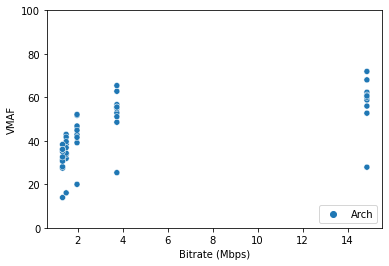

[53.15804742  0.32178159 99.98255035  1.12013803]


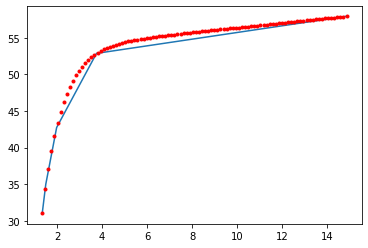

LightroomInteriorDayLight


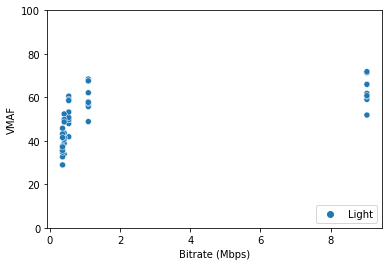

[ 59.71655468   0.41610998 206.72837752   6.12671347]


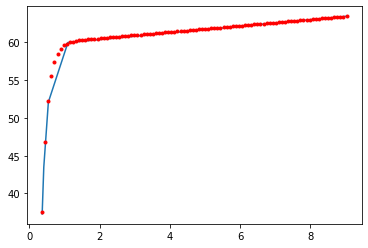

office


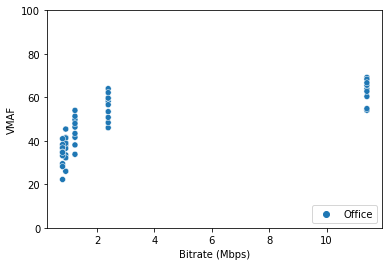

[56.68815008  0.4636039  83.62184582  1.5855137 ]


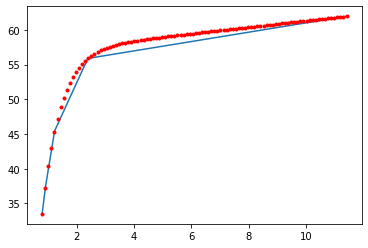

RealisticRendering


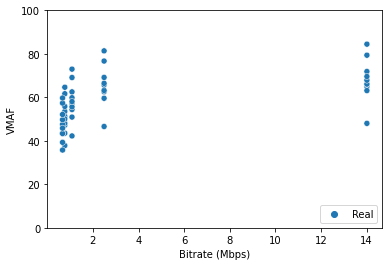

[65.14189358  0.21457343 79.88028464  2.25188401]


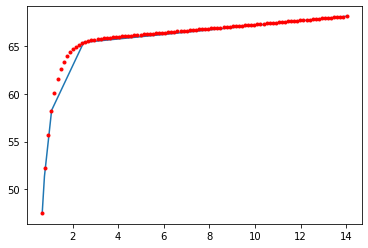

XoioBerlinFlat


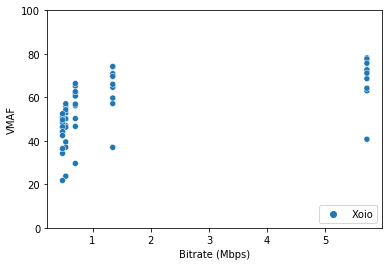

[ 63.96815374   0.78986905 150.61683694   3.97452644]


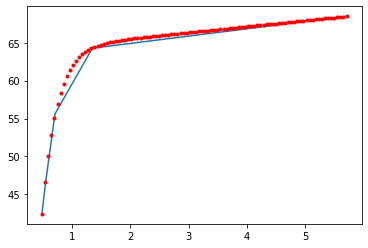

In [5]:
if __name__ == '__main__':
    main()